# CS-433 Project 1: ML Higgs 
Changling Li, Julian Blackwell, Luca Bataillard

In [21]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [22]:
from proj1_helpers import *
from implementations import *

In [23]:
DATA_TRAIN_PATH = '../data/train.csv'
y_train, x_train, ids_train = load_csv_data(DATA_TRAIN_PATH)
column_names = np.genfromtxt(DATA_TRAIN_PATH, delimiter=",", dtype=str)[0, 2:]

## Exploratory data analysis

### Step 1: Inspecting the labels

We begin our data analysis by inspecting the `y` array of labels. According to the documentation, all labels are $-1$ for background 'b' and $1$ is for signal 's'. We check this below:

In [24]:
((y_train == 1) | (y_train == -1)).all()

True

### Step 2: Inspecting the features

We first read appendix B of the original Higgs paper and discover several key points:
* All variables are floating point and continuous, apart from `PRI_jet_num`, which ranges in $\{0, 1, 2, 3\}$
* Undefined values are denoted by the value $-999.0$

We inspect the features of `tx` to confirm these claims. We can see that `PRI_jet_num` corresponds to column 22. We decide to do no further processing to this variable and treat it as continuous. We notice several undefinded variables.

In [25]:
N, D = x_train.shape
print(f"Number of rows: {N}")
print(f"Number of columns: {D}")

Number of rows: 250000
Number of columns: 30


In [26]:
for i, colname in enumerate(column_names):
    col = x_train[:5, i]
    print(f"{i:2} - {colname:30s}: {col}")

 0 - DER_mass_MMC                  : [ 138.47   160.937 -999.     143.905  175.864]
 1 - DER_mass_transverse_met_lep   : [ 51.655  68.768 162.172  81.417  16.915]
 2 - DER_mass_vis                  : [ 97.827 103.235 125.953  80.943 134.805]
 3 - DER_pt_h                      : [27.98  48.146 35.635  0.414 16.405]
 4 - DER_deltaeta_jet_jet          : [ 9.10e-01 -9.99e+02 -9.99e+02 -9.99e+02 -9.99e+02]
 5 - DER_mass_jet_jet              : [ 124.711 -999.    -999.    -999.    -999.   ]
 6 - DER_prodeta_jet_jet           : [   2.666 -999.    -999.    -999.    -999.   ]
 7 - DER_deltar_tau_lep            : [3.064 3.473 3.148 3.31  3.891]
 8 - DER_pt_tot                    : [41.928  2.078  9.336  0.414 16.405]
 9 - DER_sum_pt                    : [197.76  125.157 197.814  75.968  57.983]
10 - DER_pt_ratio_lep_tau          : [1.582 0.879 3.776 2.354 1.056]
11 - DER_met_phi_centrality        : [ 1.396  1.414  1.414 -1.285 -1.385]
12 - DER_lep_eta_centrality        : [ 2.00e-01 -9.99e+02 -9.9

### Step 3: Summary statistics

By computing the summary statistics on the data, we notice that undefined values are not present in all columns. However, in columns where they are present, they comprise a large proportion of the data. There are too many such rows to be simply discarded as outliers, so we will treat them as regular datapoints for the time being.

We also notice that each feature follows a very different distribution. To ease model computational cost and improve model performance, we will scale the dataset by subtracting the mean and dividing by the standard deviation. 

In [27]:
display_summary_statistics(x_train, column_names=column_names)

   Column                      |   Mean   |  Median  | Std dev  |   Max    |    Min   | # Undefined | % Undef 
 0-DER_mass_MMC                |  -49.023    105.012    406.345   1192.026   -999.000    38114.000     15.246
 1-DER_mass_transverse_met_lep |   49.240     46.524     35.345    690.075      0.000        0.000      0.000
 2-DER_mass_vis                |   81.182     73.752     40.829   1349.351      6.329        0.000      0.000
 3-DER_pt_h                    |   57.896     38.468     63.656   2834.999      0.000        0.000      0.000
 4-DER_deltaeta_jet_jet        | -708.421   -999.000    454.480      8.503   -999.000   177457.000     70.983
 5-DER_mass_jet_jet            | -601.237   -999.000    657.971   4974.979   -999.000   177457.000     70.983
 6-DER_prodeta_jet_jet         | -709.357   -999.000    453.019     16.690   -999.000   177457.000     70.983
 7-DER_deltar_tau_lep          |    2.373      2.492      0.783      5.684      0.208        0.000      0.000
 8-DER_pt

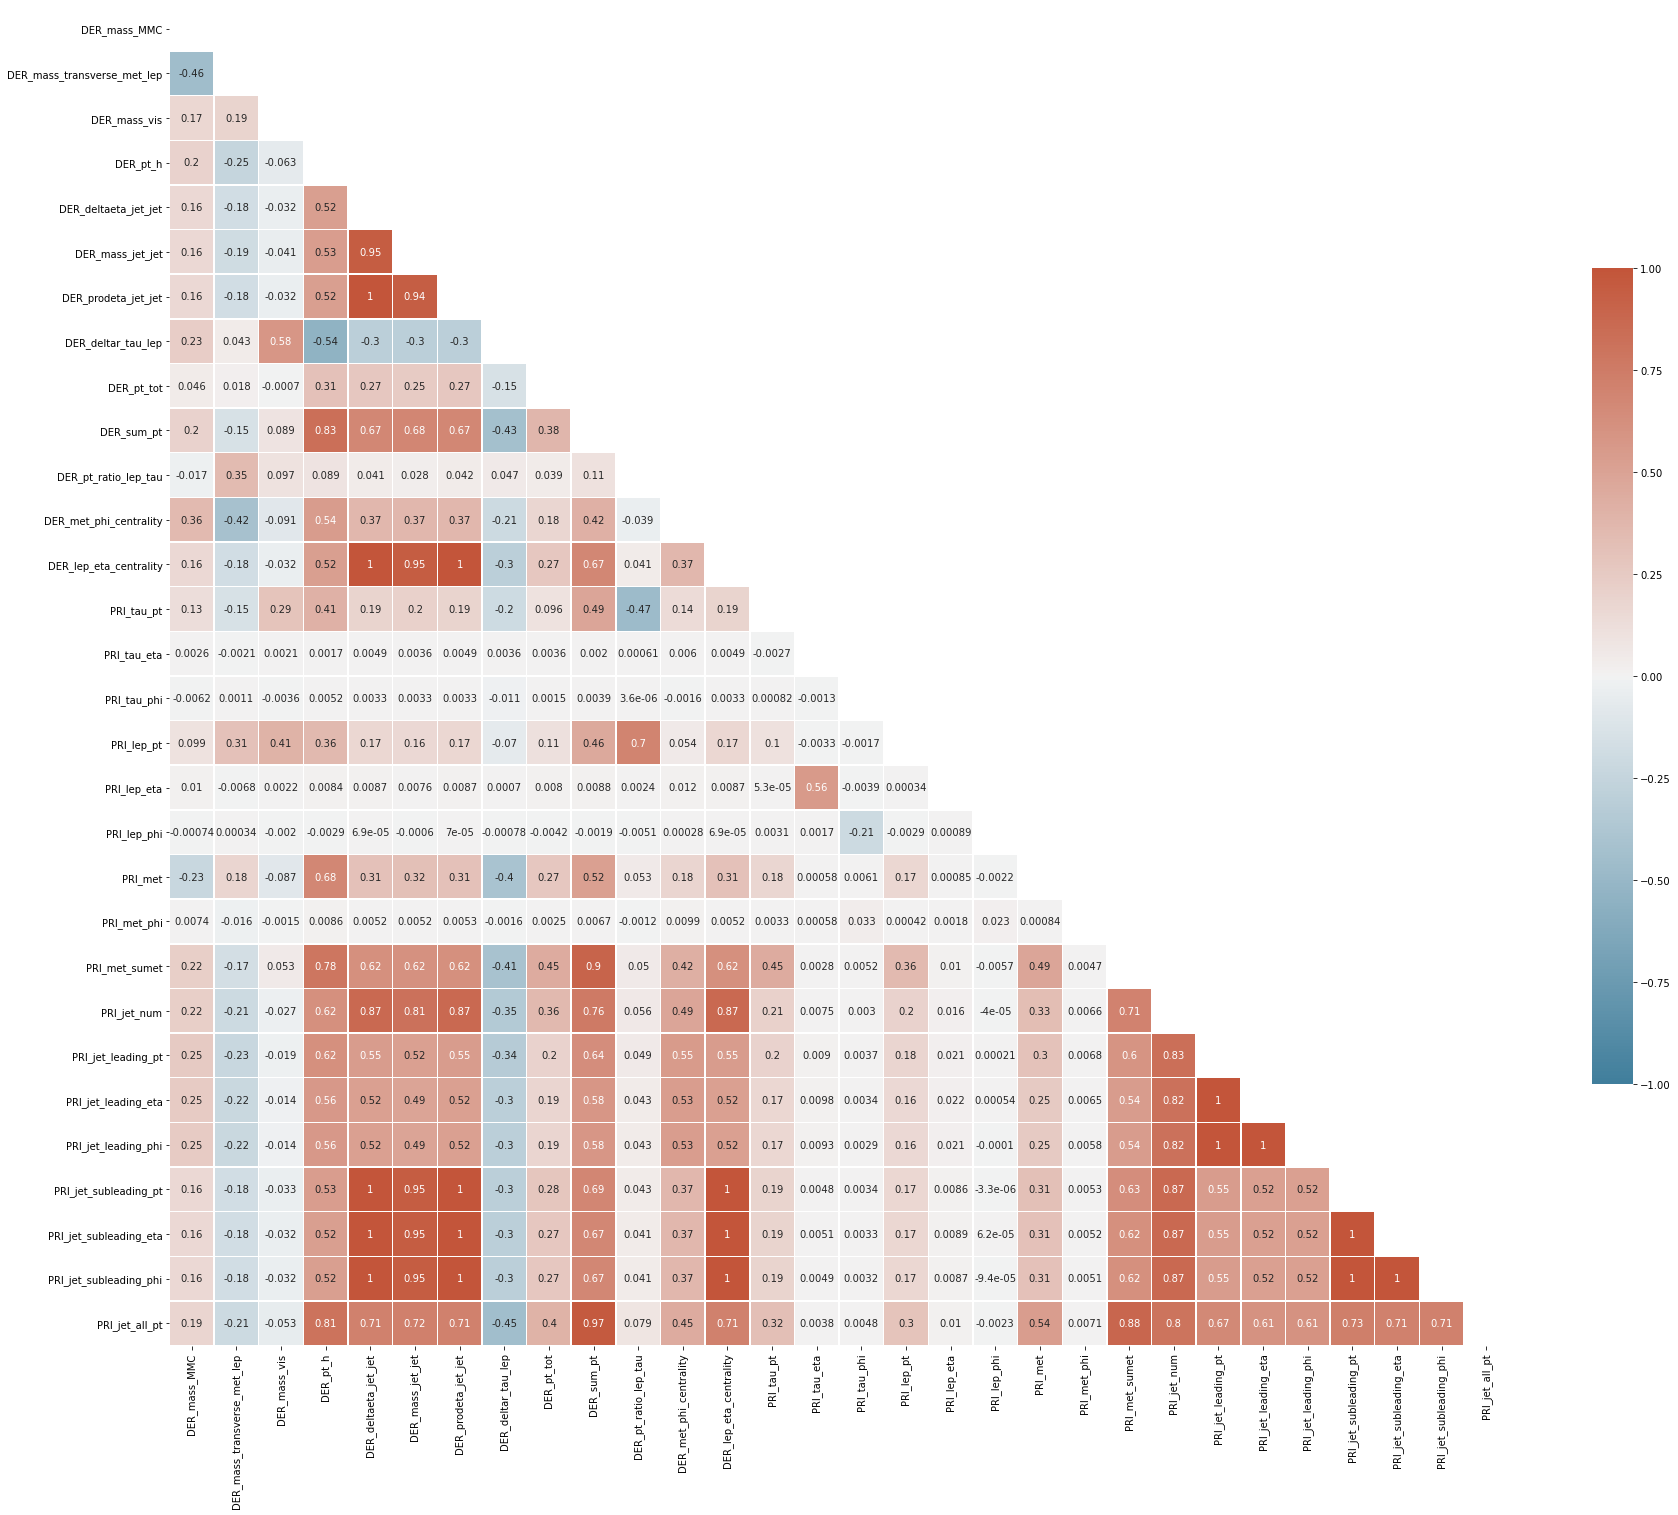

In [28]:
plot_corr_matrix(x_train, column_names)

## Feature processing

### Handling missing values

After initial data analysies, we notice that a small number of columns have over $70\%$ invalid values. We decide to discard such columns. 

Some other columns still have invalid values, we decide to replace the $-999$ by the mean of all non-invalid values in that column.

In [29]:
def handle_invalid(x, column_names=None):
    """Takes a dataset and a list of columns names. Removes columns with too many invalid values. 
    Replaces remaining invalid values with mean of its respective column."""

    invalid_value = -999.0
    invalid_threshold = 0.7

    # Remove columns with a pct of invalid values above 70%
    pct_undef = (x <= invalid_value).mean(axis=0)
    below_thresh = pct_undef < invalid_threshold

    print(f"{(~below_thresh).sum()} columns are above the invalid threshold. Removing", end="\n\t")
    if column_names is not None:
        print(*column_names[~below_thresh], sep="\n\t")
        column_names = column_names[below_thresh]

    x = x[:, below_thresh]

    # Replace -999 with mean value of remaining values for each column still in dataset
    for i in range(x.shape[1]):
        col = x[:, i]
        mean = col[col > invalid_value].mean()
        col[col <= invalid_value] = mean

    return x, column_names


x_train, column_names = handle_invalid(x_train, column_names)

7 columns are above the invalid threshold. Removing
	DER_deltaeta_jet_jet
	DER_mass_jet_jet
	DER_prodeta_jet_jet
	DER_lep_eta_centrality
	PRI_jet_subleading_pt
	PRI_jet_subleading_eta
	PRI_jet_subleading_phi


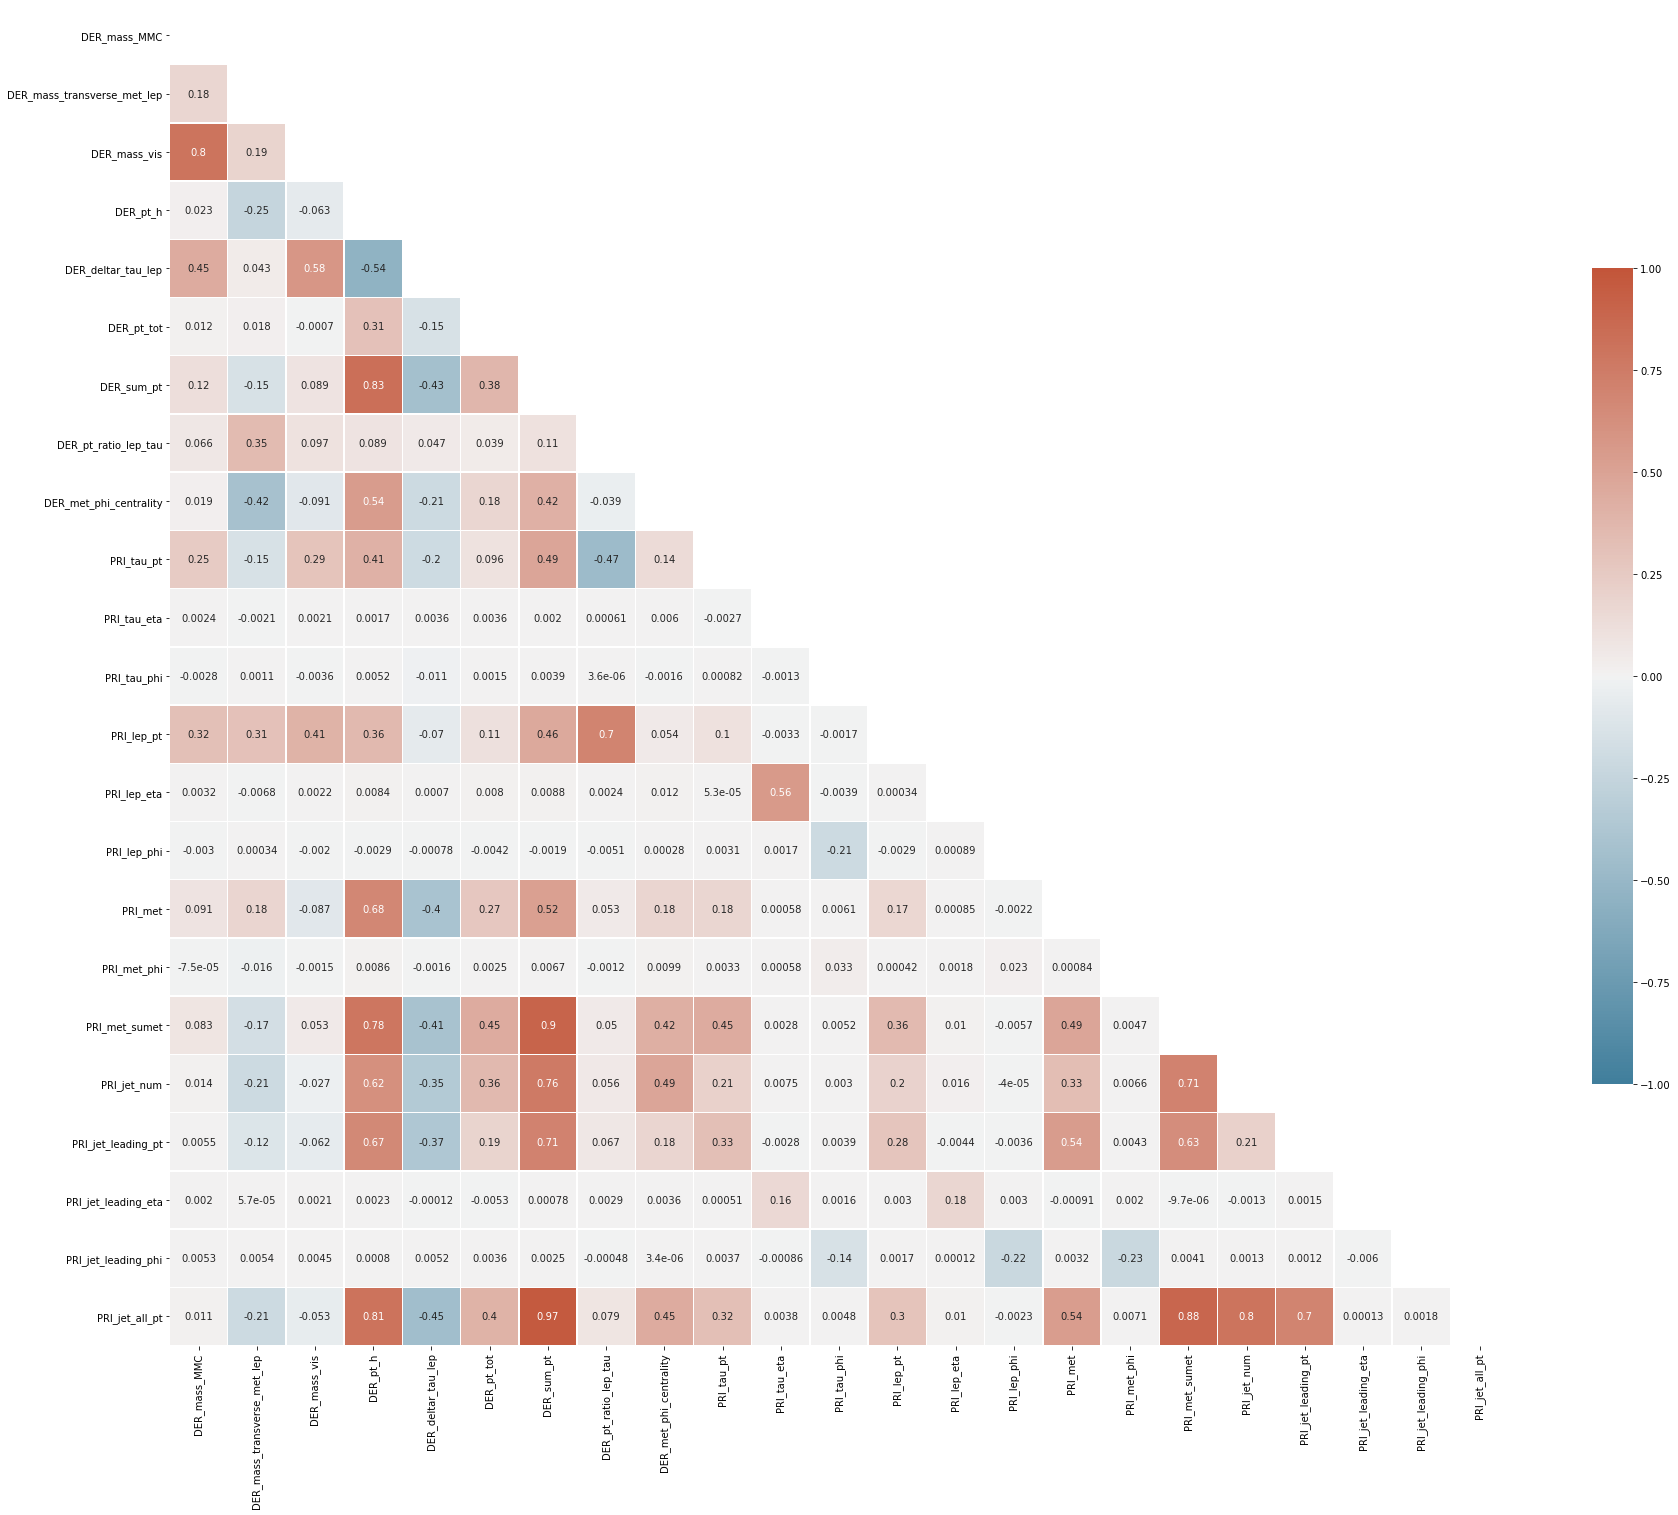

In [30]:
plot_corr_matrix(x_train, column_names)

### Removing correlated columns
We observe that a subset of columns are highly correlated to other so we decide to remove these as well.

In [31]:
def remove_columns(data, col_ids):
    return np.delete(data, col_ids, axis=1)

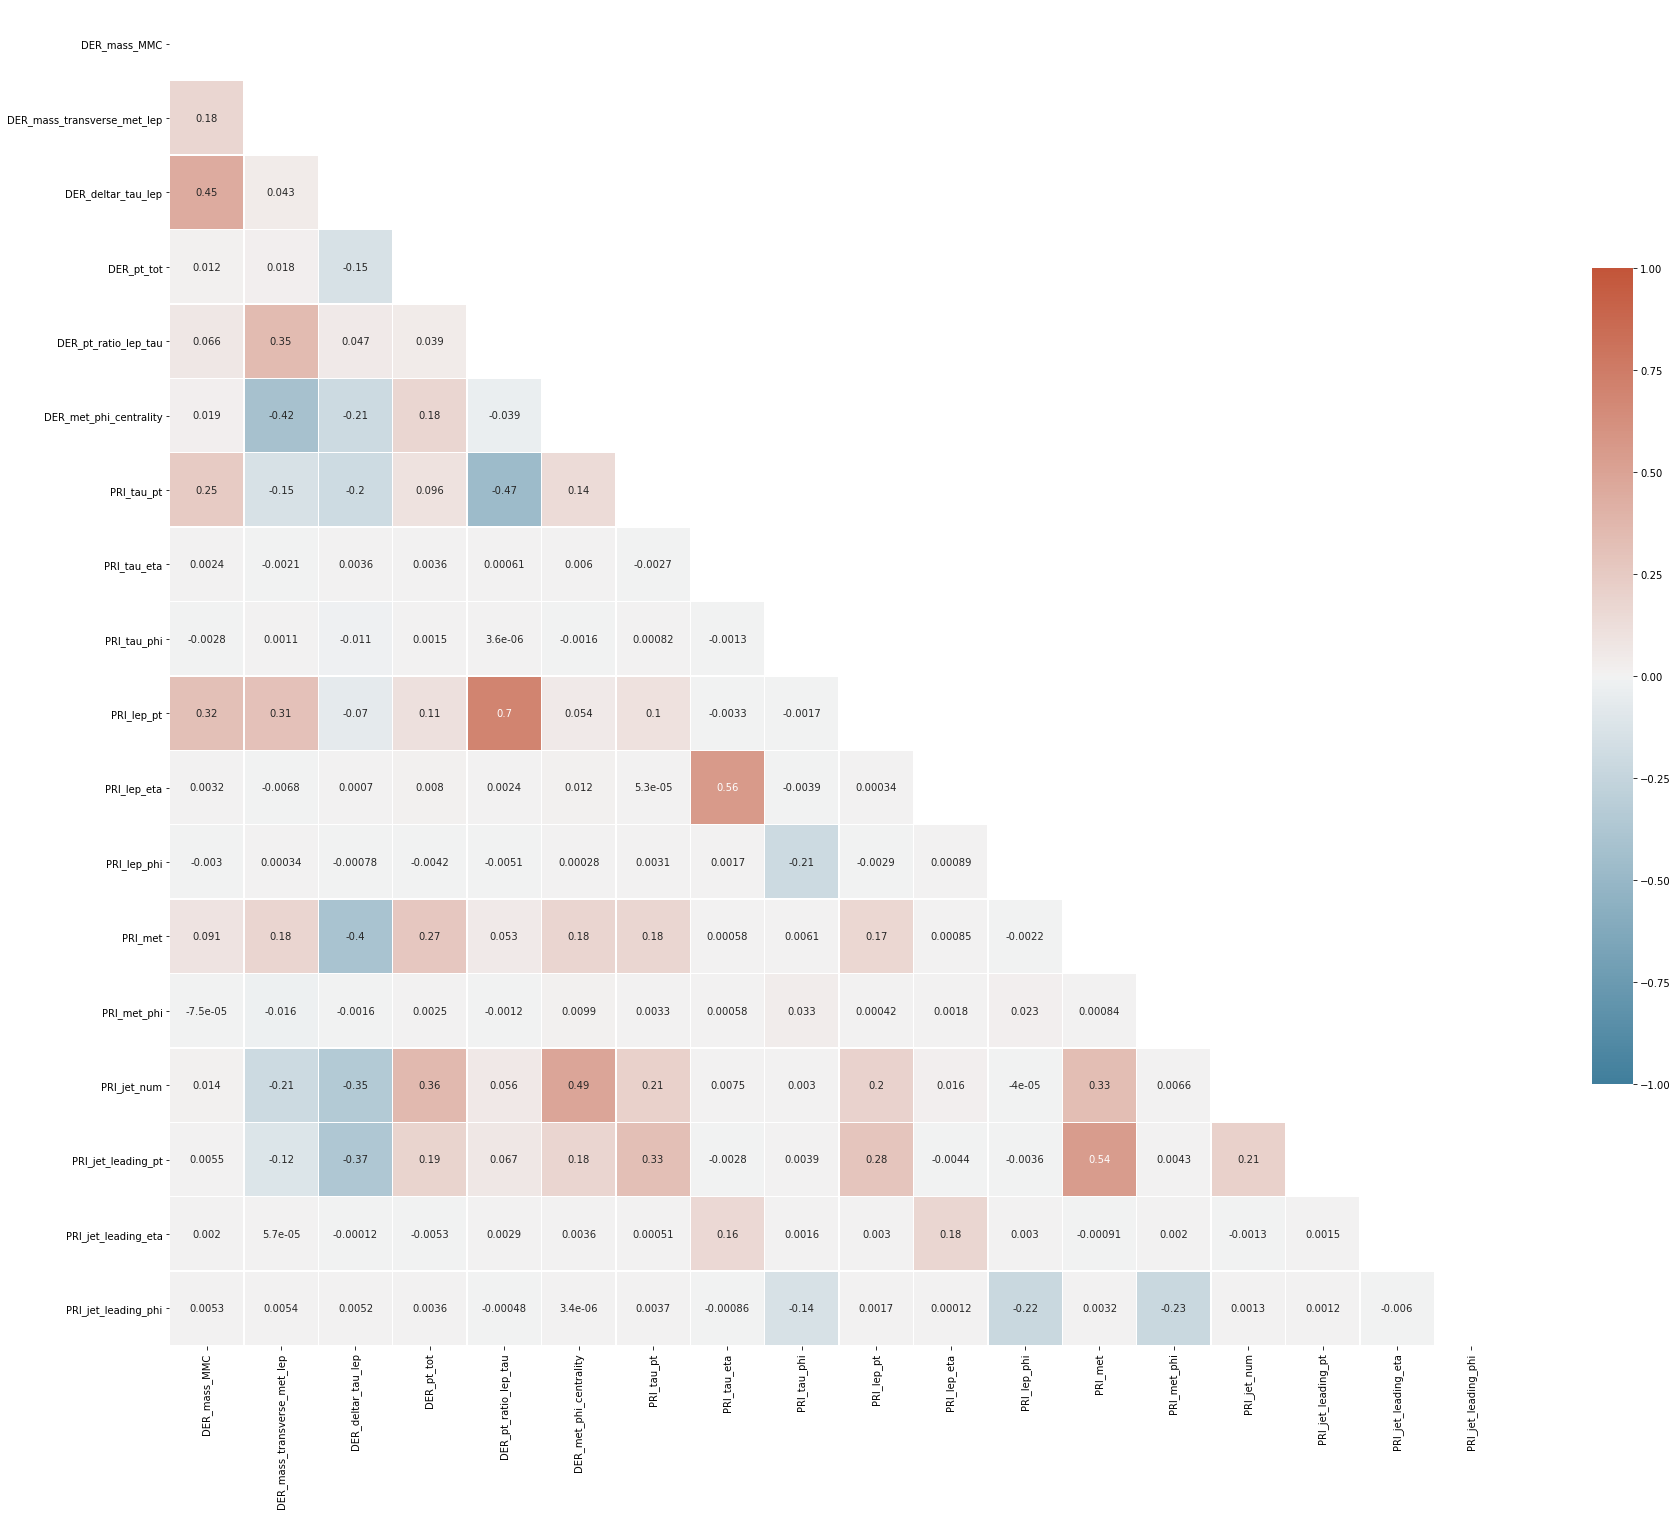

In [32]:
to_remove = ['DER_pt_h', 'DER_sum_pt', 'PRI_met_sumet', 'PRI_jet_all_pt', 'DER_mass_vis']
to_remove = [np.where(column_names == name)[0][0] for name in to_remove]
to_remove = np.array(to_remove)
x_train, column_names = remove_columns(x_train, to_remove), np.delete(column_names, to_remove)
plot_corr_matrix(x_train, column_names)

### Removing outliers
We make our training data more robust by removing outliers in the data. We choose to remove all such data points which are 2 standard deviations further from the mean.

In [33]:
# Detect outlier rows for each column
def detect_outlier(column, max_dev=2):
    column_mean = np.mean(column)
    column_std = np.std(column)
    dist_from_mean = abs(column - column_mean)
    outlier_filter = dist_from_mean > max_dev * column_std
    ids = np.arange(len(column))
    return ids[outlier_filter]

outlier_row_ids = set()
for i in range(x_train.shape[1]):
    outlier_row_ids.update(detect_outlier(x_train[:, i], 3))
print(len(outlier_row_ids) / x_train.shape[0])

0.090744


In [34]:
x_outlier_free = np.delete(x_train, list(outlier_row_ids), axis=0)

In [35]:
y_outlier_free = np.delete(y_train, list(outlier_row_ids), axis=0)

### Feature expansion
Now that correlated columns and outliers have been removed, we decide to expand the features. We first add all pairwise multiplied columns as features

In [36]:
from itertools import combinations_with_replacement

def expand_poly(data, degree=2):
    init = np.zeros((data.shape[0], 1))
    cs = combinations_with_replacement(data.T, degree)
    for c in cs:
        new_column = np.ones(init.shape[0])
        for col in c:
            new_column = np.multiply(new_column, col)
        init = np.hstack((init, new_column.reshape((-1,1))))
    init = np.delete(init, 0, axis=1)
    return init

In [37]:
pairwise_poly = tuple([expand_poly(x_outlier_free, i) for i in range(1, 3)])
pairwise_poly = np.hstack(pairwise_poly)

In [38]:
def construct_poly(data, power):
    return np.power(data, power)

In [39]:
# Test accuracy
def eval_performance(weights, test_y, test_x):
    y_predicted = predict_labels(weights, test_x)
    accuracy = len(y_predicted[y_predicted == test_y]) / len(y_predicted)
    return accuracy

In [40]:
# Cross validate with ridge regression to approximate model performance
def cross_val_acc(y, tx, k_fold=10, eval_=eval_performance, seed=1, lambda_=1e-15):
    k_indices = build_k_indices(y, k_fold, seed)
    score_te = 0

    for k in range(k_fold):
        te_indices = k_indices[k]
        tr_indices = k_indices[~(np.arange(k_indices.shape[0]) == k)].reshape(-1)

        y_te, x_te = y[te_indices], tx[te_indices]
        y_tr, x_tr = y[tr_indices], tx[tr_indices]

        w, fit_loss = ridge_regression(y_tr, x_tr, lambda_)
        score_te += eval_(w, y_te, x_te)

    return score_te/k_fold

In [41]:
# Check degree performance
for k in range(4, 15):
    col_polynomials = tuple([construct_poly(x_outlier_free, i) for i in range(3, k)])
    col_polynomials = np.hstack(col_polynomials)
    x_expanded = np.hstack((pairwise_poly, col_polynomials))
    x_expanded, _, _ = standardize(x_expanded)
    print('Degree : ', k-1, ' - ', cross_val_acc(y_outlier_free, x_expanded))

Degree :  3  -  0.7609432053143286
Degree :  4  -  0.7726760811226959
Degree :  5  -  0.7722361532708636
Degree :  6  -  0.7771149531476836
Degree :  7  -  0.7786063085653951
Degree :  8  -  0.7794729664335049
Degree :  9  -  0.7802032466675466
Degree :  10  -  0.7800800668690335
Degree :  11  -  0.7803748185297611
Degree :  12  -  0.7804584048216092
Degree :  13  -  0.7802296423386565


We then add polynomials of higher order of all columns ($X^3$, $X^4$, ... upto $X^{12}$)

In [42]:
col_polynomials = tuple([construct_poly(x_outlier_free, i) for i in range(3, 13)])
col_polynomials = np.hstack(col_polynomials)
x_expanded = np.hstack((pairwise_poly, col_polynomials))

### Model selection
We now select our model which will be ridge regression. We perform grid search and 5-fold cross-validation to optimize our hyperparameters to find the best training weights.

We start off with ridge regression:

In [43]:
x_expanded_std, x_exp_mean, x_exp_std = standardize(x_expanded)

ridge_regression_params = {
    "lambda_": [2, 1, 0.5, 0.1, 1e-02, 1e-03, 5e-05, 2e-05, 1e-05, 1e-06, 1e-07, 1e-08, 1e-09, 1e-10, 1e-15, 1e-20],
}

best_ridge_params = parameter_grid_search(y_outlier_free, x_expanded_std, ridge_regression, compute_mse, 
                                    ff_params=ridge_regression_params, verbose=False)[0]["params"]
print(best_ridge_params)

{'lambda_': 1e-15}


In [44]:
# Cross validate to predict accuracy
cross_val_acc(y_outlier_free, x_expanded_std, **best_ridge_params)

0.7804584048216092

In [45]:
# Retrain model with entire dataset
submit_weights, _ = ridge_regression(y_outlier_free, x_expanded_std, **best_ridge_params)

### Creating submission

In [46]:
DATA_TEST_PATH = '../data/test.csv'
_, x_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [47]:
x_test, _ = handle_invalid(x_test)

7 columns are above the invalid threshold. Removing
	

In [48]:
# Remove correlated columns
x_test = remove_columns(x_test, to_remove)

In [49]:
# Feature expansion
pairwise_poly = tuple([expand_poly(x_test, i) for i in range(1, 3)])
pairwise_poly = np.hstack(pairwise_poly)

col_polynomials = tuple([construct_poly(x_test, i) for i in range(3, 13)])
col_polynomials = np.hstack(col_polynomials)
x_expanded = np.hstack((pairwise_poly, col_polynomials))

In [50]:
# Standardize
x_test_std, _, _ = standardize(x_expanded, x_exp_mean, x_exp_std)

In [51]:
# Predict labels and create submission
OUTPUT_PATH = '../output/test_pred.csv'
y_pred = predict_labels(submit_weights, x_test_std)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)